In [1]:
# !pip install --upgrade huggingface_hub
# !pip install datasets
# !pip install pandas numpy scikit-learn opencv-python tensorflow
# !pip install ipywidgets
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import numpy as np

In [2]:
# !pip install zenodo-get
DATA_PATH ='/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
LABEL_DATA_PATH = 'OLIVES_Dataset_Labels/full_labels/Biomarker_Clinical_Data_Images.csv'

In [3]:
dataset = pd.read_csv(LABEL_DATA_PATH)
dataset.head()

,Path (Trial/Arm/Folder/Visit/Eye/Image Name),Scan (n/49),Atrophy / thinning of retinal layers,Disruption of EZ,DRIL,IR hemorrhages,IR HRF,Partially attached vitreous face,Fully attached vitreous face,Preretinal tissue/hemorrhage,...,DRT/ME,Fluid (IRF),Fluid (SRF),Disruption of RPE,PED (serous),SHRM,Eye_ID,BCVA,CST,Patient_ID
0,/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif,1,0,0,0,0,1,0.0,1.0,0.0,...,0,1,0,0,0,0,1,61,575,201
1,/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000001.tif,2,0,0,0,0,1,0.0,1.0,0.0,...,0,1,0,0,0,0,1,61,575,201
2,/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000002.tif,3,0,0,0,0,1,0.0,1.0,0.0,...,0,1,0,0,0,0,1,61,575,201
3,/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000003.tif,4,0,0,0,0,1,0.0,1.0,0.0,...,0,1,0,0,0,0,1,61,575,201
4,/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000004.tif,5,0,0,0,0,1,0.0,1.0,0.0,...,0,0,0,0,0,0,1,61,575,201


In [4]:
class OLIVESDataset(Dataset):
    def __init__(self, csv_path, image_root, mode='train', transform=None):
        """
        Initialize the dataset.

        :param csv_path: Path to the CSV file containing image paths and labels.
        :param image_root: Root directory containing images.
        :param mode: Either 'train' or 'test'. Determines data splitting or augmentation.
        :param transform: torchvision transforms to apply to the images.
        """
        self.csv_path = csv_path
        self.image_root = image_root
        self.mode = mode
        self.transform = transform

        # Load data from the CSV file
        self.data = pd.read_csv(csv_path)

        # Validate columns
        if 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)' not in self.data.columns or 'BCVA' not in self.data.columns:
            raise ValueError("CSV file must contain 'image_path' and 'label' columns.")

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve an image and its label.

        :param idx: Index of the sample to retrieve.
        :return: Tuple (image, label)
        """
        # Get image path and label from the data frame
        image_path = self.image_root + self.data.iloc[idx]['Path (Trial/Arm/Folder/Visit/Eye/Image Name)']
        image_path = image_path.replace(" ", "_")
        label = self.data.iloc[idx]['BCVA']

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image = image / 255.0

        # Apply transformations
        if self.transform:
            image = self.transform(image.astype(np.float32))

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Example usage
if __name__ == "__main__":
    csv_path = LABEL_DATA_PATH
    image_root = DATA_PATH 

    # Define transforms
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Initialize dataset
    dataset = OLIVESDataset(csv_path=csv_path, image_root=image_root, mode='train', transform=train_transform)

    # Test dataset loading
    print(f"Dataset size: {len(dataset)}")
    image, label = dataset[0]
    print(f"Image shape: {image.shape}, Label: {label}")


Dataset size: 9408
Image shape: torch.Size([3, 496, 504]), Label: 61


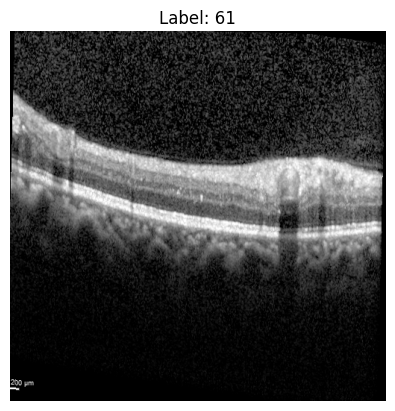

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import cv2
import torch

# Convert tensor image back to a displayable format
image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
image = (image * 0.5 + 0.5)  # Undo normalization
image = np.clip(image, 0, 1)  # Ensure it's between 0 and 1

# Display the image and label
plt.imshow(image)
plt.title(f"Label: {label.item()}")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [6]:
class OCTDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = pd.read_csv(df)
        self.img_dir = img_dir  # Corrected usage of the `img_dir` parameter
        # Ensure the relevant columns are strings
        self.df.iloc[:, 0] = self.df.iloc[:, 0].astype(str)  # File name column
        self.df.iloc[:, 1] = self.df.iloc[:, 1].astype(str)  # Directory column
        self.transforms = transforms.Compose([
            transforms.ToTensor()  # Converts PIL Image to Tensor
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Construct the full image path
        img_path = self.img_dir + self.df.iloc[idx]['Path (Trial/Arm/Folder/Visit/Eye/Image Name)']
        img_path = img_path.replace(" ", "_")
        im = Image.open(img_path).convert("L")

        # Apply transformations (if any)
        if hasattr(self, 'transforms'):
            image = self.transforms(im)
        else:
            image = im  # Return raw image if no transforms are defined
        
        label = self.df.iloc[idx, 2]
        patient_label = self.df.iloc[idx, 3]
        return image, label, patient_label


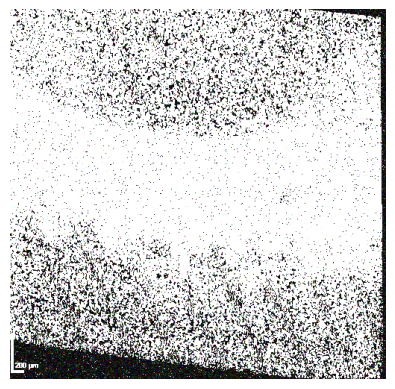

In [7]:
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

# Custom noise addition transformations
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

# Define noise addition functions
def add_salt_pepper(image, amount):
    s_vs_p = 0.5
    noisy_img = np.copy(image)

    num_salt = np.ceil(amount * image.size * s_vs_p).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_img[coords[0], coords[1], :] = 1

    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p)).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_img[coords[0], coords[1], :] = 0

    return noisy_img

def add_gaussian_noise(image, mean=0, variance=0.01):
    noise = np.random.normal(mean, np.sqrt(variance), image.shape)
    noisy_img = image + noise
    return np.clip(noisy_img, 0, 1)

# Custom noise addition transformations
class AddSaltPepperNoise(object):
    def __init__(self, amount=0.01):
        self.amount = amount

    def __call__(self, img):
        return Image.fromarray(add_salt_pepper(np.array(img), self.amount).astype(np.uint8))

class AddGaussianNoise(object):
    def __init__(self, mean=0, variance=0.01):
        self.mean = mean
        self.variance = variance

    def __call__(self, img):
        return Image.fromarray((add_gaussian_noise(np.array(img), self.mean, self.variance) * 255).astype(np.uint8))

# Define the complete transformation pipeline
transform_pipeline = transforms.Compose([
    AddSaltPepperNoise(0.01),
    AddGaussianNoise(0, 0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.ToPILImage()  # Convert tensor back to PIL Image for displaying
])

# Function to load, transform, and display an image
def display_transformed_image(img_path, transform):
    # Load the image
    img_path = img_path.replace(" ", "_")
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"No image found at {img_path}")

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to PIL for transformation
    image = Image.fromarray(image)

    # Apply transformations
    transformed_image = transform(image)

    # Display the transformed image
    plt.imshow(transformed_image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    
# Example usage
if __name__ == "__main__":
    img_dir = DATA_PATH  # Root directory containing images
    df = pd.read_csv(LABEL_DATA_PATH)  # CSV file containing image paths and labels
    idx = 0  # Index of the image to process

    # Construct the full image path
    image_path = img_dir + df.iloc[idx]['Path (Trial/Arm/Folder/Visit/Eye/Image Name)']

    # Display the transformed image
    display_transformed_image(image_path, transform_pipeline)


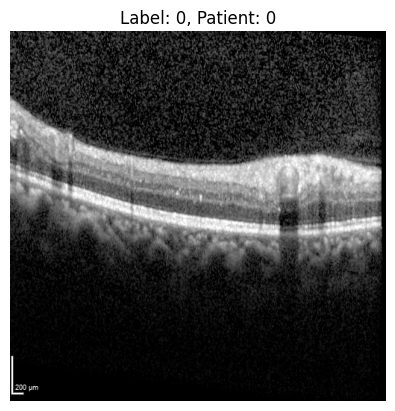

In [8]:
import matplotlib.pyplot as plt

# Assuming LABEL_DATA_PATH and DATA_PATH are defined
oct_data = OCTDataset(LABEL_DATA_PATH, DATA_PATH)

# Access the first image and its labels
image, label, patient_label = oct_data[0]

# Display the image using matplotlib
plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove unnecessary dimensions
plt.title(f"Label: {label}, Patient: {patient_label}")
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


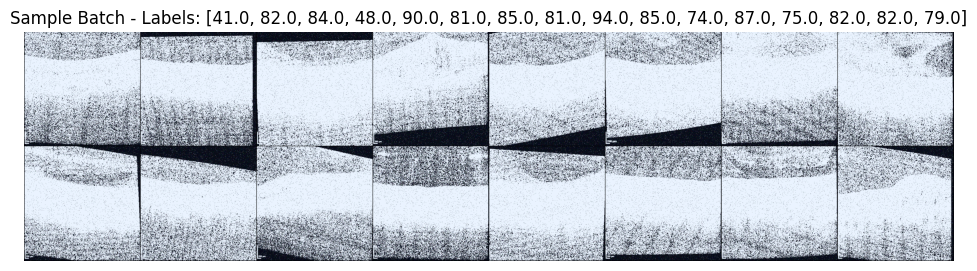

Batch Image Shape: torch.Size([16, 3, 496, 504]), Labels: tensor([68., 41., 91., 86., 83., 88., 60., 84., 80., 79., 41., 88., 85., 72.,
        85., 84.])


In [9]:
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils


# Custom noise addition transformations
class AddSaltPepperNoise:
    def __init__(self, amount=0.01):
        self.amount = amount

    def __call__(self, img):
        return Image.fromarray(self._add_salt_pepper(np.array(img), self.amount).astype(np.uint8))

    @staticmethod
    def _add_salt_pepper(image, amount):
        s_vs_p = 0.5
        noisy_img = np.copy(image)

        # Add salt
        num_salt = int(np.ceil(amount * image.size * s_vs_p))
        salt_coords = [np.random.randint(0, dim - 1, num_salt) for dim in image.shape[:2]]
        noisy_img[salt_coords[0], salt_coords[1]] = 255

        # Add pepper
        num_pepper = int(np.ceil(amount * image.size * (1. - s_vs_p)))
        pepper_coords = [np.random.randint(0, dim - 1, num_pepper) for dim in image.shape[:2]]
        noisy_img[pepper_coords[0], pepper_coords[1]] = 0

        return noisy_img


class AddGaussianNoise:
    def __init__(self, mean=0, variance=0.01):
        self.mean = mean
        self.variance = variance

    def __call__(self, img):
        return Image.fromarray((self._add_gaussian_noise(np.array(img), self.mean, self.variance) * 255).astype(np.uint8))

    @staticmethod
    def _add_gaussian_noise(image, mean=0, variance=0.01):
        noise = np.random.normal(mean, np.sqrt(variance), image.shape)
        noisy_img = image + noise
        return np.clip(noisy_img, 0, 1)


# Define transformation pipeline
transform_pipeline = transforms.Compose([
    AddSaltPepperNoise(amount=0.01),
    AddGaussianNoise(mean=0, variance=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def get_image_path(idx, data_frame, root_dir):
    """
    Constructs the full image path for a given index.
    """
    relative_path = data_frame.iloc[idx]['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].strip()
    relative_path = relative_path.replace(" ", "_")
    full_path = root_dir + relative_path
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Image not found at {full_path}")
    return full_path


class OLIVESDataset(Dataset):
    def __init__(self, csv_path, image_root, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_root = image_root
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Get full image path
            image_path = get_image_path(idx, self.data, self.image_root)
        except FileNotFoundError as e:
            print(e)
            return None, None

        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # Extract label (e.g., BCVA)
        label = self.data.iloc[idx]['BCVA']
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


def visualize_batch(dataloader):
    """Visualize a batch of images from the dataloader."""
    images, labels = next(iter(dataloader))
    grid = vutils.make_grid(images, normalize=True)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Sample Batch - Labels: {labels.tolist()}")
    plt.axis("off")
    plt.show()


def main():
    # Define paths
    DATA_PATH = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
    LABEL_DATA_PATH = os.path.join('OLIVES_Dataset_Labels/full_labels/Biomarker_Clinical_Data_Images.csv')

    # Initialize dataset and dataloader
    dataset = OLIVESDataset(csv_path=LABEL_DATA_PATH, image_root=DATA_PATH, transform=transform_pipeline)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

    # Visualize a batch of images
    visualize_batch(dataloader)

    # Example: Iterate through a batch
    for images, labels in dataloader:
        if images is None or labels is None:
            continue  # Skip missing entries
        print(f"Batch Image Shape: {images.shape}, Labels: {labels}")
        break


if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


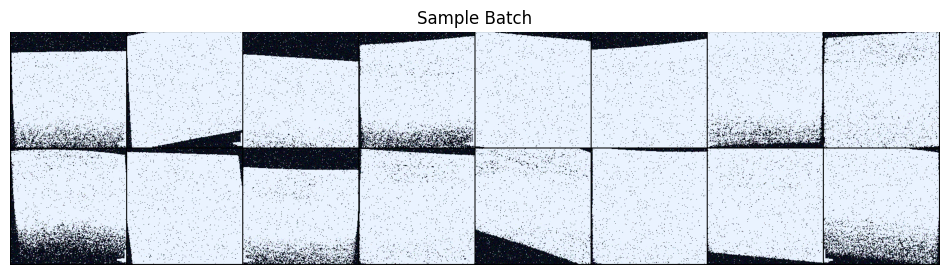

Sample Biomarkers: [-0.13401332 -0.261912   -0.05841752 -0.2031736   0.6954324  -0.6820481
  0.89510024 -0.3063627   1.4603562   1.1407154  -0.15934992 -0.03261814
 -0.03261814 -0.09023943]
Sample Labels: [72. 59. 77. 80. 81. 75. 59. 93. 57. 61. 83. 82. 84. 64. 69. 85.]
Batch Image Shape: torch.Size([16, 3, 224, 224])
Biomarker Tensor Shape: torch.Size([16, 14])
Labels Tensor Shape: torch.Size([16])


In [10]:
import torch
import pandas as pd
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Preprocessing for clinical and biomarker data
def preprocess_biomarkers(data_frame, biomarker_cols):
    """
    Normalize biomarker and clinical data columns for model compatibility.
    Args:
    - data_frame (pd.DataFrame): DataFrame containing the biomarkers and clinical data.
    - biomarker_cols (list): List of column names to normalize.
    Returns:
    - data_frame (pd.DataFrame): Normalized DataFrame.
    """
    for col in biomarker_cols:
        if col in data_frame:
            data_frame[col] = data_frame[col].fillna(data_frame[col].mean())  # Impute missing values
            data_frame[col] = (data_frame[col] - data_frame[col].mean()) / data_frame[col].std()  # Normalize
    return data_frame


class EnhancedOLIVESDataset(Dataset):
    def __init__(self, csv_path, image_root, biomarker_cols, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_root = image_root
        self.biomarker_cols = biomarker_cols
        self.transform = transform

        # Preprocess biomarkers
        self.data = preprocess_biomarkers(self.data, biomarker_cols)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Handle missing image paths
        try:
            image_path = get_image_path(idx, self.data, self.image_root)
        except FileNotFoundError as e:
            print(e)
            return None, None, None

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Extract clinical labels and biomarkers
        biomarker_data = self.data.iloc[idx][self.biomarker_cols].values.astype(np.float32)
        label = self.data.iloc[idx]['BCVA']  # Example: BCVA as the main label

        # Convert to tensors
        biomarker_tensor = torch.tensor(biomarker_data, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return image, biomarker_tensor, label_tensor


# Define image transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet or other models
    transforms.RandomHorizontalFlip(p=0.5),  # Augment with horizontal flipping
    AddSaltPepperNoise(amount=0.01),  # Custom noise addition
    AddGaussianNoise(mean=0, variance=0.01),  # Custom Gaussian noise
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])


def visualize_combined_batch(dataloader):
    """Visualize a batch of images with corresponding labels and biomarkers."""
    images, biomarkers, labels = next(iter(dataloader))
    grid = vutils.make_grid(images, normalize=True)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Sample Batch")
    plt.axis("off")
    plt.show()
    print("Sample Biomarkers:", biomarkers[0].numpy())
    print("Sample Labels:", labels.numpy())


def main():
    # Paths
    DATA_PATH = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
    LABEL_DATA_PATH = os.path.join('OLIVES_Dataset_Labels/full_labels/Biomarker_Clinical_Data_Images.csv')

    # Define biomarker columns
    biomarker_columns = [
        'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages',
        'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face',
        'Preretinal tissue/hemorrhage', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)',
        'Disruption of RPE', 'PED (serous)', 'SHRM'
    ]

    # Dataset and DataLoader
    dataset = EnhancedOLIVESDataset(csv_path=LABEL_DATA_PATH, image_root=DATA_PATH, 
                                    biomarker_cols=biomarker_columns, transform=transform_pipeline)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

    # Visualize a batch
    visualize_combined_batch(dataloader)

    # Example: Iterate through the dataset
    for images, biomarkers, labels in dataloader:
        if images is None or biomarkers is None or labels is None:
            continue  # Skip missing entries
        print(f"Batch Image Shape: {images.shape}")
        print(f"Biomarker Tensor Shape: {biomarkers.shape}")
        print(f"Labels Tensor Shape: {labels.shape}")
        break


if __name__ == "__main__":
    main()
